# Análise de popularidade de smartphones e seus fabricantes

Ao executar esse programa, será procurado novos modelos de smartphones na web, e caso não estejam no banco de dados, serão adicionaos. Após isso, serão pesquisados tweets publicados nas últimas 24h, sobre as empresas e seus produtos mobile encontrados na pesquisa anterior. Com isso, será fornecido gráficos sobre frequência e popularidade desses produtos e empresas.

## Bibliotecas usadas

In [ ]:
import json
import requests
from bs4 import BeautifulSoup
import re
import time
from py2neo import Graph, Node, Relationship, GraphService, NodeMatcher
# Estabeleço prontamente a conexão com o banco de dados:
gp = Graph(password='**********')
import pandas as pd
import datetime
from datetime import timedelta
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.sentiment import SentimentIntensityAnalyzer
from itranslate import itranslate as itrans
from matplotlib import pyplot as plt

##  1 - Funções e constantes

In [ ]:
# 1 - Funções

BEARER_TOKEN = "**************"
#Dicionário de contextos:
ContextsIDs = {'Samsung produto': 48.10026331316, 'Samsung':47.10026364234, 'Huawei mobile':48.1336311163471065088,
               'Huawei': 47.10029202046, 'Vivo produto':48.1336315382135545861, 'Vivo':47.1392151841727664129,
               'Microsoft produto':48.10026414931, 'Realme':47.1310940668089397248, 'Realme mobile':48.1336326057914351617,
               'Nokia':47.10027594377, 'Nokia mobile':48.1336329110813962240, 'Honor':47.1108683119589117953,
               'Honor mobile':48.1336320863767949313, 'Infinix':47.1108688857178869760, 'Xiomi':47.10041367948,
               'Xiomi mobile':48.1336313466894761986, 'Apple':47.10026364281, 'Apple Iphone':48.10024011738,
               'OnePlus':47.911222222865408000, 'OnePlus Mobile':48.1336319284679639043, 'Lenovo':47.10026646794,
               'Lenovo mobile':48.133633968661732147, 'Motorola':47.10027762047, 'LG eletronics':47.10027187398,
               'LG mobile':48.10042421309, 'ASUS':47.10029190351, 'ASUS mobile':48.1336331310608994305,
               'ZTE':47.1108688338507096065, 'OPPO':47.912729836665237505, 'PPO mobile':48.1336315382135545861,
               'Tecno':47.1108685692261953538, 'Sony':47.10026738409, 'Sony Xperia':48.10040410872,
               'Snapdragon':48.1367159032637612032, 'MediaTek':47.10043230662, 'Android':47.10026820777, 
               'Apple-IOS':48.10044903039, 'Retail':45.781974596706635776, 'Cell Phones':66.848920700073123840, 
                'Carrefour': 47.946776540196495360, 'Mobile': 30.848985956778561538
              }

#Dicionário contador de citações:
#%env modelos_citados={}


#Stopwords para a análise dos textos(adicionar continuamente):
sw_adicionais = ['co', 'né', '-','http', 'r', 'pra', "''", '\\n', '...', 'q', 'só', '\\n\\n', 'n', 'vcs', 'assim', 'todos',
                 'tá', 'outros', '\\nhttps', 'pq', 'vão', 'm', 't', '"', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
                  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
                'https','14″','siga', 'compre', 'concorra' 'algum', 'funda', 'ter', 'usar', 'ponto', 'ver',
                 ' vai', 'vcs', 'assim', 'todos', 'outros', 'tá', 'poucas','etc','pq', 'vão', 'se',
                 'aqui', 'todas','tipo','saiba', 'parede', 'arredar', 'entrar', 'naquela', '1','2','3','4','5','6','7','8',
                  '9','10','11','12','13','14','15','16','17','18','19','20', 'reais', 'cada', 'pega', 'abra','faz', 'vez',
                 'acho', 'apenas', 'coisa', 'ser', 'pode', 'uso', 'confira', 'fico', 'então', 'ia', 'neste', 'algum']



stopwords = set(nltk.corpus.stopwords.words("portuguese") + list(punctuation) + sw_adicionais )



#Retorna a os tweets pesquisados de acordo com os parâmetros de interesse:
def search_twitter(query, tweet_fields, bearer_token = BEARER_TOKEN):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    url = "https://api.twitter.com/2/tweets/search/recent?query={}&{}&{}&start_time={}&end_time={}".format(query, max_results, tweet_fields, start_time, end_time)

    response = requests.request("GET", url, headers=headers)

    print(response.status_code)

    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()
    


#Transforma os elementos do dicionario de contextos em string de formato adequado:
def formata(lista):
    b= f"context:{lista[0]}"
    for i in lista:
        b = b + f" OR {i}"
    return b
    
        
        
#Agrega elementos da lista e cria nova lista lista:
def segmenta(lista):
    l = len(lista)
    ix = l//4
    novalista = [lista[:ix], lista[ix:2*ix], lista[2*ix:3*ix], lista[3*ix:]]
    return novalista
        
        
        
#Verifica se o modelo está no texto:
def compare(s1, s2):
    s1=s1.upper().split(" ")
    s2=s2.upper().split(" ")
    if(set(s1).issubset(set(s2))):
        return True
    else:
        return False

    
        
#Retorna lista de 100 palavras com suas frequências, em ordem decrescente:
def top_trendings(texto):
    palavras = word_tokenize(texto.lower())
    stopwords = set(nltk.corpus.stopwords.words("portuguese") + list(punctuation))
    palavras_sem_stopwords = [palavra for palavra in palavras if palavra not in stopwords]
    frequencia = FreqDist(palavras_sem_stopwords)
    return frequencia.most_common()



#Cria imagem WordCloud:
def criar_wc(lista):
    wordcloud = WordCloud(collocations=False, stopwords=stopwords,
                      background_color="black",
                      width=1600, height=800).generate(str(lista))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(wordcloud);
    wordcloud.to_file("wordcloud.png")
    
    
    
#Análise de Sentimento. Traduz o texto e retorna um valor entre [Negativo(-1,1)Positivo]:
def analisa_sentimento(tweet):
    trad = itrans(tweet, to_lang="en")
    sia = SentimentIntensityAnalyzer()
    sentimento =sia.polarity_scores(trad)
    return sentimento['compound']



## 2 - Web scraping e primeiras entradas no banco de dados

   A partir de um web scraping na página tudocelular.com, foi criado uma dicionário, selecionando os smartphones comercializados no brasil, importados ou não, lançados nos últimos 3 anos. O banco de dados escolhido foi o Neo4j, baseado em grafos, que nos será muito útil, pois foi criado especificamente para armazenar e processar relacionamentos entre dados.


In [ ]:
%%time
dic = {}
tx = gp.begin()


#contador do número de produtos
a = 0

#coleta e análise das páginas em ordem decrescente de lançamento:
for n in range(0,33):
    if n==0:
        page = requests.get(f'https://www.tudocelular.com/celulares/fichas-tecnicas.html')
    else:
        page = requests.get(f'https://www.tudocelular.com/celulares/fichas-tecnicas_{n}.html')
    
    soup = BeautifulSoup(page.text, 'html.parser')

    #coletando informações a partir da classe e tag de interesse:
    modelos_lista = soup.find(id='cellphones_list')
    modelos_lista_itens = modelos_lista.find_all('h4')
    
    
    # Limpando e armazenando em um dicionário, com as fabricantes como chave: 
    for modelo in modelos_lista_itens:

        fabricante = str(modelo.contents[0])
        fabricante = re.split('strong>|</', fabricante)
        fb = fabricante[1]

        md = modelo.contents[1]
        
        a=a+1
        
        #Criando nodos para cada modelo e os rotulando com o nome do fabricante:
        Produto = Node("Produto",fb, nome=md, contador=0)
        #Verifica se o modelo já está no banco:
        no = gp.nodes.match(fb, nome=md).first()
        if no==None:
            tx.create(Produto)
        
        
#Criando dicionário com os produtos:
        if fb in dic:
            dic[fb].append(md)
        else:
            dic[fb] = [md]
            
            
#Finalmente envia ao banco:
gp.commit(tx)
    
    
print('Quantidade de produtos encontrada:', a)
 

Quantidade de produtos encontrada: 1683
Wall time: 17.4 s


## 3 - Consumindo a API do Twitter e análise de sentimento

   O banco de dados escolhido foi o Neo4j, baseado em grafos, que nos será muito útil, pois foi criado especificamente para armazenar e processar relacionamentos entre dados. Antes de consumir a API, armazeno os produtos em que temos interesse. Esse projeto sofreu diversas modificações em sua própria finalidade, durante seu desenvolvimento. As limitações para usuários padrão do Twitter inpôs desafios constantes, que sempre foram resolvidos com o intuito de manter o objetivo inicial básico: criar uma ferramenta que auxílie tomadas de decisões no varejo de smartphones. Ao fim, também é mostrado uma WordCloud com as 100 palavras mais usadas no último dia. Devido ao limite de tweets que posso requisitar, pesquisas de tweets entre os dias 19 e 26 foram feitas previamente, para alimentar o banco do de dados. Para isso, foi utilizado um simples loop no código abaixo.

   Testando a api do twitter, foi observada uma quantidade consideravel de repetições nos tweets requisitados, o que acontece com menos frequência ao solicitar em intervalos de tempos sucessivos. Claro, mesmo com toda essas restrições no nosso universo de pesquisa, ainda obtemos tweets irrelevantes para nossa análise.

   Apesar de não ser necessário para o meu objetivo primário, também armazeno os tweets pesquisados, pois compartilho o conteúdo do banco, de forma que a qualidade do meu filtro de dados possa ser avaliada. Também, possibilita um suporte para outros projetos futuros.

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
Foram encontrados 3 novos nós e 0 relações, dentre os 21

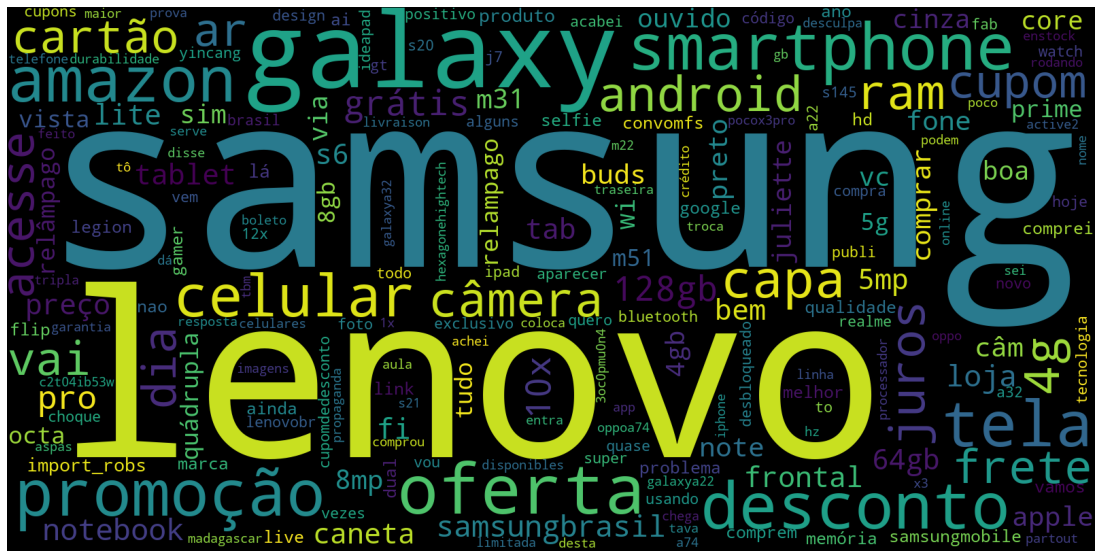

In [ ]:
%%time

cont_twt = 0  #contador de tweets
cont_twr = 0 #contador de tweets repetidos
cont_rel = 0 #contador de relações
tweets_do_dia = "" #onde tweets do dia são armazenados para visualização das trends do dia


#Parâmetros da pesquisa:
tweet_fields = "tweet.fields=created_at"
#tweet_fields = "tweet.fields=context_annotations"  #utilizado para encontrar as ContextsIDs
max_results="max_results=100"
dt = datetime.datetime.now() - timedelta(days=1)
start_time = dt.strftime("%Y-%m-%dT%H:%M:%SZ")                     
end_time = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")  


#todos os prudutos de determinado fabricante estão na mesma pesquisa devido ao limite de taxa de requisição dos tweets.
#Outra limitação é a do tamanho do query (512 caracteres), sendo necessário dividir a lista de produtos em sublistas:

for fb in dic.keys():
    contextos = list(ContextsIDs.values())
    for sub in segmenta(contextos):
        contextos = formata(sub)
        #obs: por algum motivo o operador place_country:BR para o query, parou de funcionar quando estava finalizando o projeto.
        query = f"({fb}) (lang:pt) (-is:retweet) ({contextos})"
        #Solicitando pesquisa utilizando a função criada em 1.2:
        json_response = search_twitter(query=query, tweet_fields=tweet_fields, bearer_token=BEARER_TOKEN)
        cont = json_response['meta']['result_count']
        cont_twt = cont_twt + cont


        #Filtrando textos:
        txt = []
        dtt = []
        for i in range(0, cont):
            txt.append(json_response['data'][i]['text']) 
            dtt.append(json_response['data'][i]['created_at']) 
        

        #Inserindo tweets no banco, sempre verificando se o texto já foi inserido:
        c = len(txt)
        for j in range(0,c):
            tx = gp.begin()
            #Cria nó com o rótulo do fabricante atual da iteração:
            no = gp.nodes.match("Tweet", fb, texto=txt[j]).first()
            
            tweets_do_dia += " " + str(txt[j])

            if no==None:
                # ************************Análise de Sentimento********************
                #Foi necessário traduzir os tweets, pois a a ferramenta de análise VADER não possui suporte para o português.
                #Cada tweet é analisado individualmente, retornando um valor entre [Negativo(-1,1)Positivo]:
                cont_sentimento = analisa_sentimento(txt[j])
                new = Node("Tweet", fb, texto=txt[j], Quantidade_de_Sentimento=cont_sentimento, publicado_em=dtt[j])
                tx.create(new)

                #Como cada produto(modelo) já está relacionado a um fabricante pelo rótulo, basta relacionarmos os tweets aos produtos.
                #Verifica se o modelo do produto é mencionado no tweet e cria a relação:
                for item in dic[fb]:
                    if compare(f"{fb} {item}",txt[j]):
                        #cria relação:
                        fab = Node("Produto", fb,  nome=item)
                        newr = Relationship(new, "SOBRE", fab)
                        tx.create(newr)
                        
                        print(fb+" "+item)
                        #Salvando citação no dicionário:
                        if (fb+" "+item) in modelos_citados.keys():
                            modelos_citados[fb+" "+item] += 1
                        else:
                            modelos_citados[fb+" "+item]=1
                        cont_rel=cont_rel + 1
            else:
                cont_twr = cont_twr +1
            


            gp.commit(tx)
    

#Adicionando as palavras mais usadas do dia ao banco, sempre contando o número de ocorrências total:
ttd = top_trendings(tweets_do_dia)

for trend in ttd:
    new = Node("Trend", palavra=trend[0], contador=trend[1] )
    no = gp.nodes.match("Trend", palavra=trend[0]).first()
    if no==None:
        tx = gp.begin()
        tx.create(new)
        gp.commit(tx)
    else:
        gp.merge(Node("Trend", palavra=trend[0], contador=no["contador"]+trend[1]), "Trend", "palavra")




print(f"Foram encontrados {cont_twt - cont_twr} novos nós e {cont_rel} relações, dentre os {cont_twt} tweets pesquisados.")

print(f"Os palavras mais usadas do dia são:")
criar_wc(tweets_do_dia.lower())
    
    
    
    

    

    
#Verificaçãode das informações recebidas:
#print(json.dumps(json_response, indent=4, sort_keys=True))

#Consulto o horário de fim da pesquisa, para saber quando posso fazer outra(cerca de 10 minutos depois).
print(datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ"))

## 4 - Visualização dos dados armazenados

   Aqui, faço uso da biblioteca pandas para vizualizar os dados armazenados. Basicamente, a ideia é fornecer três tipos 
diferentes de vizualização:

1. Trends em WordCloud relativo a todos os tweets armazenados até o momento;
2. Gráfico de popularidade das 20 empresas mais populares; 
3. Modelos de smartphones mais comentados.

   Assim, desejo fornecer ferramentas que auxiliem profissionais do varejo na tomada de decisões que impulsionem vendas. Como, por exemplo, na decisão de quais produtos comprar, de campanhas de promoção, e em saber quais produtos mantêm-se 
populares, além das tendências.

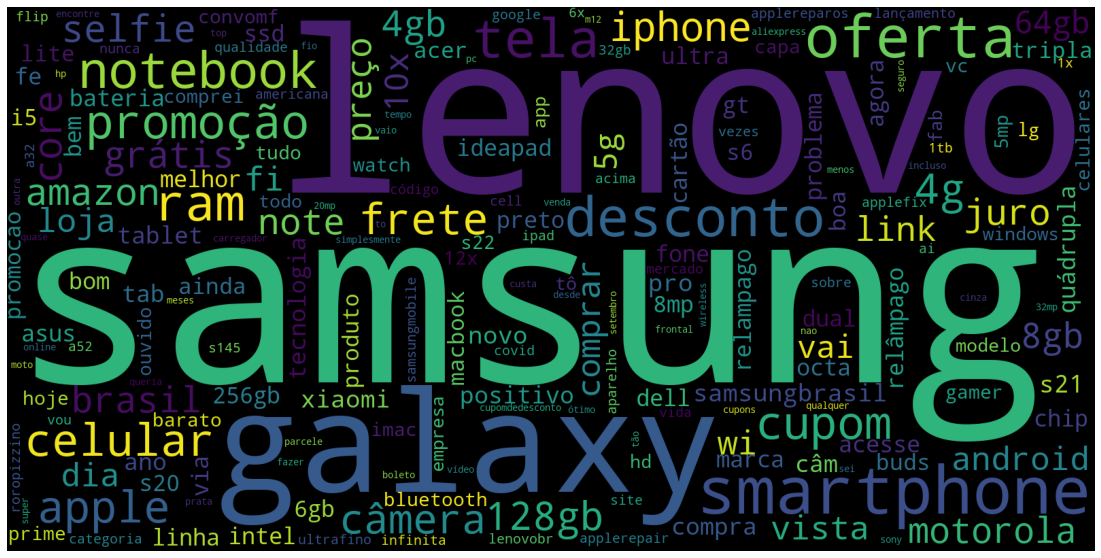

In [ ]:
#  1)

#Importando trends e suas frequências, e criando WordCloud:
no = gp.nodes.match("Trend").all()
ls_palavras = ""
for node in no:
    ls_palavras += f"{node['palavra']}  "*node['contador']
    
criar_wc(ls_palavras)




In [ ]:
# 2)

# Para vizualizarmos a a popularidade das marcas:
pop = []
for fb in dic.keys():
    popul = 0.0
    no = gp.nodes.match("Tweet", fb).all()
    for node in no:
        #A popularidade de cada marca é calculada pela simplies soma das propriedades 'Quantidade_de_Sentimento':
        #popul= popul + float(node["Quantidade_de_sentimento"])
        popul = popul + node["Quantidade_de_Sentimento"]
    pop.append(popul)


#Cria dataframe:
df = pd.DataFrame({"Marca":list(dic.keys()) ,"Índice": pop })
df


 


,Marca,Índice
0,Poco,0.5106
1,Samsung,213.2250
2,Redmi,1.2883
3,Honor,0.0000
4,Oppo,0.0000
5,Xiaomi,2.1647
6,Huawei,1.2470
7,UMIDIGI,0.0000
8,vivo,0.7738
9,Microsoft,0.0000


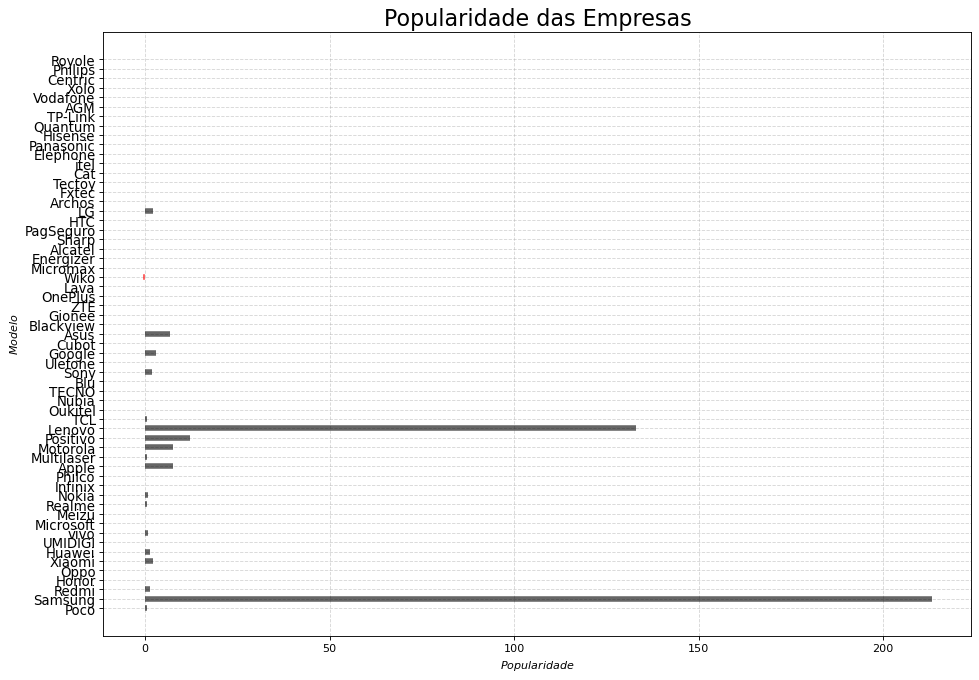

In [ ]:
#Gráfico de popularidade:

#Criando esquema de cores:
df['colors'] = ['red' if x < 0 else 'black' for x in df['Índice']]

#Plot dos dados:
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=df.index, xmin=0, xmax=df.Índice, color=df.colors, alpha=0.6, linewidth=5)

# Customizações:
plt.gca().set(ylabel='$Modelo$', xlabel='$Popularidade$')
plt.yticks(df.index, df.Marca, fontsize=12)
plt.title('Popularidade das Empresas', fontdict={'size':20})
plt.grid(linestyle='--', alpha=0.5)

#Finalmente:
plt.show()

#Acredito que haja um problema com a análise de sentimentos de tweets sobre a empresa Positivo, por causa do nome da mesma.

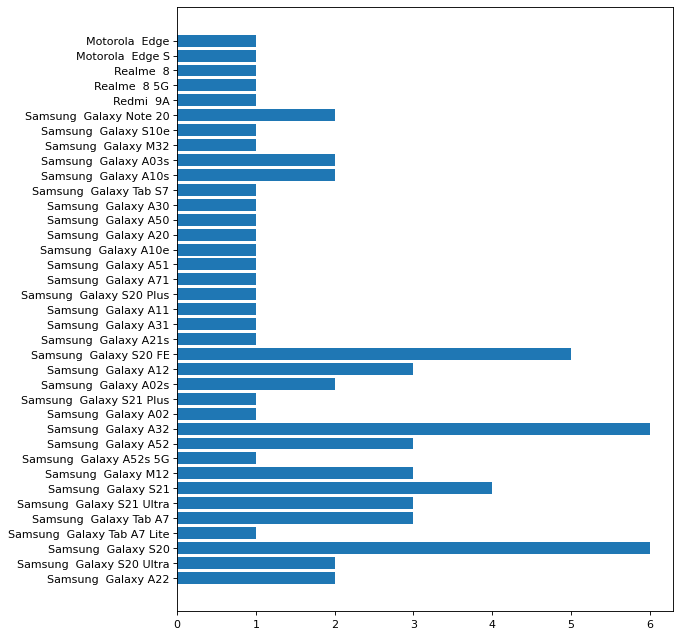

In [ ]:
#  3)

#Calculando o número de tweets que citaram cada produto, através da relação 'SOBRE':
mdls_citados = {}
for fb in dic.keys():
    no = gp.nodes.match("Produto", fb).all()
    for produto in no:
        item = produto["nome"]
        count = len(gp.match((None, produto), "SOBRE"))
        if count > 0:
            if (fb+" "+item) in mdls_citados.keys():
                mdls_citados[fb+" "+item] += 1
            else:
                mdls_citados[fb+" "+item]=1


#Usando o dicionário com os modelos citados nos tweets pesquisados:
plt.figure(figsize=(8,10), dpi= 80)
plt.barh(list(mdls_citados.keys()), list(mdls_citados.values()) )  #, width=0.5, align='edge')
#plt.xticks(rotation=75)
plt.show()

